In [69]:
%load_ext autoreload
%autoreload 2
import emcee
import corner
import pickle
import numpy as np
import pandas as pd

from astropy import units as u
from astropy import constants as const
from astropy.table import QTable
from matplotlib import pyplot as plt
from scipy.optimize import root, brentq
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp

from load_mcxc_data import load_clusters
from cluster_functions import c
from statistics_functions import chi_squared
from equilibrium_functions import equil
from cluster import Cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
clusters, variances=load_clusters(nrows=20)

In [59]:
def load_clusters1(nrows=None, dataset='REFLEX'):
    skipfooter=0 if nrows else 1
    mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=skipfooter)
    mcxccls.columns=mcxccls.columns.str.strip()

    selected_cls=mcxccls[mcxccls['Sub-Cat'].str.strip()==dataset]


    cls_data={'M500':selected_cls['M500'],
          'L500':selected_cls['L500'],
          'R500':selected_cls['R500']
         }
    units={
        'M500': 1e14*u.Msun,
        'L500': 1e37*u.W,
        'R500':u.Mpc
    }

    cls_table=QTable(cls_data, units=units)
    
    with open ('data/'+dataset+'.p', 'rb') as fp:
        L_uncertainties=np.array(pickle.load(fp))
    L_uncertainties_conv=(L_uncertainties*1e37*u.W).to(u.erg / u.s).value
    
    return [ 
        Cluster(
            cls_table['R500'][i],
            cls_table['M500'][i],
            L500=cls_table['L500'][i],
            m500=cls_table['M500'][i],
        )
        for i in range(nrows)#(mcxccls.shape[0])
    ], [variance(cls_table['L500'][i], L_uncertainties_conv[i]) for i in range(nrows)] 

In [52]:
def variance1(luminosity, l_unc): # returns the variance on calculated temperature
     # TODO: TEST THIS NOW THAT I HAVE ADDED L_unc
    #logL=np.log10((luminosity.to(1e44*u.erg/u.s))/(1e44*u.erg/u.s))

    A=ufloat(2.88, 0.15)
    B=ufloat(45.06, 0.03)

    lum = luminosity.to(u.erg / u.s)
    
    lums_uf = ufloat(lum.value, l_unc)
    log_T = (unp.log10(lums_uf) - B) / A + np.log10(6)
    #T = (10**log_T * u.keV).to(u.GeV)

    T = 10**log_T * 1e-6 #divide by 10^6 to convert keV to GeV

    return T.std_dev *u.GeV #variances on T in GeV

In [147]:
#prepare MCMC
log_mp = np.log10(const.m_p.to(u.GeV, equivalencies=u.mass_energy()).value)

ndim, nwalkers = 2, 10
p0=np.zeros((nwalkers, ndim ))
log_sigma0 = np.random.uniform(low=-30, high=-15, size=nwalkers).astype(np.float128)
log_mx = np.random.uniform(low=-2, high=log_mp, size=nwalkers).astype(np.float128)
p0[:,0]=log_sigma0
p0[:,1]=log_mx
p0

array([[-22.92173847,  -1.77633414],
       [-19.99261935,  -0.73292023],
       [-28.11362725,  -0.81320193],
       [-22.01639295,  -1.07849588],
       [-26.84295563,  -1.23053679],
       [-15.36386956,  -0.67716388],
       [-25.85670503,  -1.16384682],
       [-29.90623562,  -1.51974737],
       [-22.56799614,  -0.92365171],
       [-19.31369213,  -1.77823284]])

In [148]:
T_data = [c.baryon_temp for c in clusters]

In [149]:
def log_lik(p0, T_data, var, clusters):
    if p0[0]<-30 or p0[0]>-15:
        return -np.inf
    if p0[1]<-2 or 10**p0[1]>const.m_p.to(u.GeV, equivalencies=u.mass_energy()).value:
        return -np.inf
    #print(p0)
    T_model = [brentq(equil, -10, 0, args=(c, p0[0], p0[1])) for c in clusters]
    X2 = chi_squared(np.power(10,T_model)*u.GeV, T_data, var)
    return (-X2/2)

In [150]:
log_lik(p0[0], T_data, variances, clusters)

<Quantity -1373.18841848>

In [151]:
n=0
sampler = emcee.EnsembleSampler(
    nwalkers, 
    ndim, 
    log_lik, 
    args=[T_data, variances, clusters])

In [152]:
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

100%|█████████████████████████████████████████| 100/100 [07:36<00:00,  4.57s/it]


In [153]:
sampler.run_mcmc(state, 1000, progress=True)

100%|█████████████████████████████████████| 1000/1000 [1:30:58<00:00,  5.46s/it]


State([[-23.91725167  -1.69416306]
 [-22.23806905  -0.14910121]
 [-22.24122327  -0.15097898]
 [-22.38699895  -0.16821912]
 [-22.48051384  -0.17434179]
 [-15.16266595  -0.12447359]
 [-22.21380512  -0.15466467]
 [-22.14029587  -0.15493268]
 [-22.22893977  -0.14769316]
 [-22.43473631  -0.17011662]], log_prob=[-90.22424797  -0.96225099  -0.73195606  -0.58636856  -0.63359685
  -6.24319009  -0.82420667  -1.90809378  -1.14953211  -0.46158359], blobs=None, random_state=('MT19937', array([ 103353354, 2927094112, 3704614870, 2305268602, 3800377618,
       2055918945, 1611898323, 3526953860,   22244491, 4285826033,
       2719836513, 1134930380, 2873060731, 1596114062, 1115077330,
       3553097228,  814025395, 2290842468, 1926611755, 2938495635,
       3935299416, 2708481102, 2299930498, 1585570663, 2108642073,
        423467399,   18993689, 3244998744, 2704424160, 2769525103,
       4204841722, 4194878426, 2969139752, 2475001771, 2910095670,
         55848607, 3636265342, 3436774920, 2185187747

In [154]:
samples = sampler.get_chain(flat=True)

In [155]:
"Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.448'

(10000, 2)


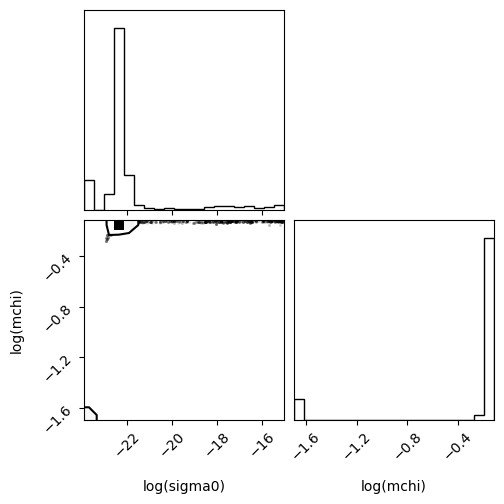

In [156]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=['log(sigma0)', 'log(mchi)'])

In [157]:
np.median(samples[:,0])

-22.355157442711047

In [158]:
np.median(samples[:,1])

-0.16126745193456082

In [107]:
np.log10(const.m_p.to(u.GeV, equivalencies=u.mass_energy()).value)

-0.027671202930545022

/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_67917/2154322017.py:9: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.scatter(np.log10(cls.baryon_temp.value),0, color='red', label='actual cluster temperature')


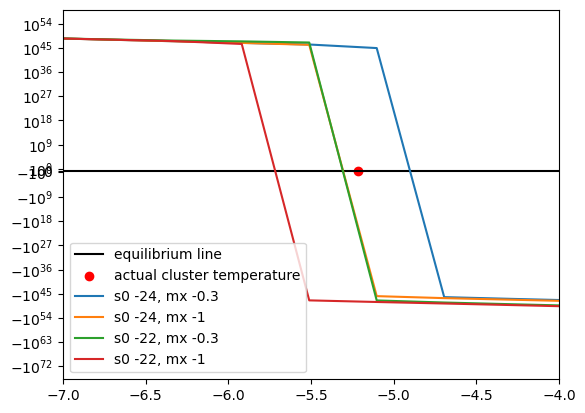

In [136]:
#troubleshoot 
log_Tbs=np.linspace(-10, 10)
cls=clusters[7]

plt.yscale('symlog')
plt.xlim(-7,-4)

plt.plot([-10,10], [0,0], color='black', label='equilibrium line')
plt.scatter(np.log10(cls.baryon_temp.value),0, color='red', label='actual cluster temperature')
plt.plot(log_Tbs, equil(log_Tbs, cls, -24, -0.3), label='s0 -24, mx -0.3')
plt.plot(log_Tbs, equil(log_Tbs, cls, -24, -1), label='s0 -24, mx -1')
plt.plot(log_Tbs, equil(log_Tbs, cls, -22, -0.3), label='s0 -22, mx -0.3')
plt.plot(log_Tbs, equil(log_Tbs, cls, -22, -1), label='s0 -22, mx -1')


plt.legend()

In [120]:
equil(log_Tbs, cls, -23.9, -1)

array([ 1.02855858e+53,  2.51179475e+52,  6.13393715e+51,  1.49794101e+51,
        3.65806134e+50,  8.93327711e+49,  2.18164768e+49,  5.32856722e+48,
        1.30195905e+48,  3.18207014e+47,  7.68270969e+46,  1.46005835e+46,
       -1.11893070e+46, -5.58519438e+46, -2.16032328e+47, -8.54705343e+47,
       -3.44794839e+48, -1.40337445e+49, -5.73292864e+49, -2.34537513e+50,
       -9.60057102e+50, -3.93078550e+51, -1.60953258e+52, -6.59075410e+52,
       -2.69883461e+53, -1.10514613e+54, -4.52547361e+54, -1.85314205e+55,
       -7.58845779e+55, -3.10740877e+56, -1.27245746e+57, -5.21060515e+57,
       -2.13369854e+58, -8.73731427e+58, -3.57785598e+59, -1.46510163e+60,
       -5.99946675e+60, -2.45673068e+61, -1.00601034e+62, -4.11952691e+62,
       -1.68691128e+63, -6.90775841e+63, -2.82866840e+64, -1.15831568e+65,
       -4.74320434e+65, -1.94230189e+66, -7.95356126e+66, -3.25691578e+67,
       -1.33367935e+68, -5.46130365e+68])

In [121]:
equil(log_Tbs, cls, -23.9, -3)

array([ 1.02855856e+53,  2.51179462e+52,  6.13393584e+51,  1.49793970e+51,
        3.65804825e+50,  8.93314598e+49,  2.18151583e+49,  5.32722994e+48,
        1.30057356e+48,  3.16696013e+47,  7.49813221e+46,  1.18150188e+46,
       -1.68545050e+46, -7.13410936e+46, -2.68148600e+47, -1.05068059e+48,
       -4.22296742e+48, -1.71636704e+49, -7.00762965e+49, -2.86623914e+50,
       -1.17316813e+51, -4.80317176e+51, -1.96672170e+52, -8.05334018e+52,
       -3.29773950e+53, -1.35039073e+54, -5.52972642e+54, -2.26437457e+55,
       -9.27241925e+55, -3.79697656e+56, -1.55482959e+57, -6.36689502e+57,
       -2.60718942e+58, -1.06762192e+59, -4.37182108e+59, -1.79022360e+60,
       -7.33081357e+60, -3.00190589e+61, -1.22925496e+62, -5.03369467e+62,
       -2.06125521e+63, -8.44066502e+63, -3.45638063e+64, -1.41535851e+65,
       -5.79577288e+65, -2.37331977e+66, -9.71854287e+66, -3.97966076e+67,
       -1.62963728e+68, -6.67322624e+68])